In [3]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel

In [17]:
def read_data(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active
    columnA_values = [cell.value for cell in sheet['A'][0:]]    
    columnB_values = [cell.value for cell in sheet['B'][0:]]
    list_dataA = [int(value) for value in columnA_values if value]
    list_dataB = [float(value) for value in columnB_values if value]

    data = pd.DataFrame({'X': list_dataA, 'Y': list_dataB})
    return data

file_path = '/content/drive/MyDrive/Uni/Aston/Coursework/Probabilistic Modeling/EnergyConsumptionData.xlsx'
df = read_data(file_path)

df

,X,Y
0,1,0.206510
1,2,0.487440
2,3,0.226630
3,4,0.682970
4,5,0.767300
...,...,...
495,496,-0.034721
496,497,-0.137870
497,498,-0.322240
498,499,-0.131280


model the data use the kernel that combines two components i = 1, 2.
kernel :
$$
\begin{aligned}
C(x, x'; \Theta) = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right],
\end{aligned}
$$


In [12]:


class GaussianProcess:
    def __init__(self, theta= 3.5688 , lambda_1=-0.001, lambda_2=0.1, r_1=0.2802, r_2=0.2898):
        self.theta = theta
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.r_1 = r_1
        self.r_2 = r_2

    def kernel(self, x1, x2):
        sin_term_1 = np.sin(np.pi / self.lambda_1 * (x1 - x2)) / self.r_1
        sin_term_2 = np.sin(np.pi / self.lambda_2 * (x1 - x2)) / self.r_2
        kernel_value = self.theta * np.exp(-0.5 * (sin_term_1 ** 2 + sin_term_2 ** 2))
        return kernel_value

    def fit(self, X, y,noise=1e-8):
        self.X_train = X
        self.y_train = y
        n = len(X)
        self.K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                self.K[i, j] = self.kernel(X[i], X[j])
        self.K += noise * np.eye(n)

    def predict(self, X_star):
        n = len(self.X_train)
        m = len(X_star)
        K_star = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                K_star[i, j] = self.kernel(X_star[i], self.X_train[j])
        K_star_star = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K_star_star[i, j] = self.kernel(X_star[i], X_star[j])
        K_inv = np.linalg.inv(self.K)
        y_mean = np.dot(np.dot(K_star, K_inv), self.y_train)
        y_cov = K_star_star - np.dot(np.dot(K_star, K_inv), K_star.T)
        return y_mean, y_cov

        

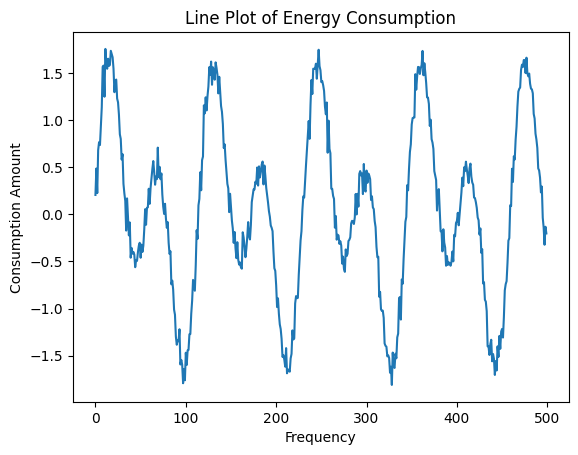

Dominant frequency: 0.018000000000000002
Amplitude: 3.5688
Period: 27777.777777777774
Phase: 10.799999999999999
Frequency: 0.018000000000000002


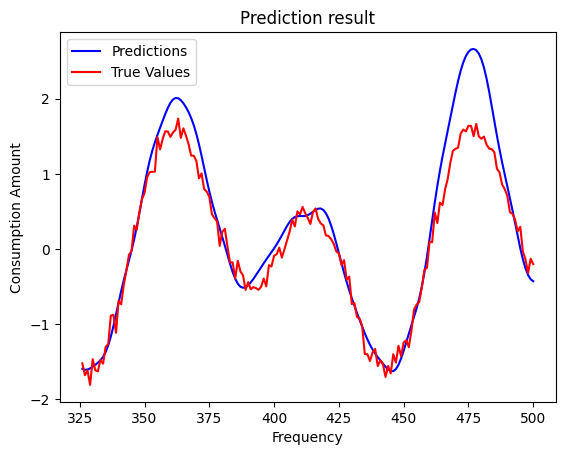

In [20]:
# Line plot of Energy Consumption
plt.plot(df['Y'])
plt.xlabel('Frequency')
plt.ylabel('Consumption Amount')
plt.title('Line Plot of Energy Consumption')
plt.show()

# Fourier Transform
x = df['X']
y = df['Y']
fft_y = np.fft.fft(y)
dominant_freq_index = np.argmax(np.abs(fft_y))
dominant_freq = np.fft.fftfreq(len(y))[dominant_freq_index]
amplitude = np.ptp(y)
period = len(y) / dominant_freq
reference_waveform = amplitude * np.sin(((2 * np.pi) / period) * dominant_freq * x)
correlation = np.correlate(y, reference_waveform, mode='same')
phase = np.argmax(correlation) / len(y) * 360

print('Dominant frequency:', dominant_freq)
print('Amplitude:', amplitude)
print('Period:', period)
print('Phase:', phase)
print('Frequency:', dominant_freq)

# Gaussian Process Regression
X = df['X']
Y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, shuffle=False)
y_noise = y_train + np.random.normal(loc=0, scale=0.1, size=X_train.shape[0])

gp = GaussianProcess(theta=3.5688, r_1=1.5556, r_2=3.6, lambda_1=55.55, lambda_2=113)
gp.fit(X_train.reset_index(drop=True), y_noise.reset_index(drop=True))
y_mean, y_cov = gp.predict(X_test.reset_index(drop=True))

# Plot predictions and true values
plt.plot(X_test, y_mean, 'b-', label='Predictions')
plt.plot(X_test, y_test, 'r-', label='True Values')
plt.title('Prediction result')
plt.xlabel('Frequency')
plt.ylabel('Consumption Amount')
# Set the labels and legend
plt.legend()

# Show the plot
plt.show()